# Introduction
Quantum computers use quantum mechanical properties such as superposition and entanglement to perform computations. In some cases, these computations can far outperform classical computers. Quantum computers store information in quantum bits which can be in a state of 0, 1, or a superposition of both. After a circuit is run on a quantum computer, the output can only be seen by measuring the quantum bits. When a quantum bit is measured, the measurement returns either 0 or 1. The probability of either outcome depends on the quantum superpositon immediately prior to measurement. The probability of measuring 0 or 1 can be found by repeating the computation and recording the measurement result many times. When using a circuit with multiple quantum bits, the probabilities distribution is over all combinations of outcomes (for two quantum bits, those are 00, 01, 10, and 11). Here, the output of a quantum circuit refers to the probability distribution over the possible measurement outcomes found by running a quantum circuit.

Quantum computers suffer from errors, also called noise. As a result of imperfect computation and measurement, the output of a quantum circuit is never exactly the same as the theory predicts. For example, if the expected output of a single quantum bit circuit is to measure 0 with 30% probability and 1 with 70% probability, the actual output might be to measure 0 with 32% probability and 1 with 68% probability. If that circuit was run again, the noise might be different leading to measuring 0 with 31% probability and 1 with 69% probability. The quantum computer noisy outputs dataset is a collection of outputs from various circuits run on different quantum computers. This dataset can help researchers to understand how noise affects quantum computers.

The dataset contains the output data from running nine circuits 2000 times each on seven different quantum computers. The dataset was generated by running code found on the [Quantum Noise Fingerprint GitHub page](https://github.com/trianam/learningQuantumNoiseFingerprint). The quantum computers are Santiago, Lima, Quito, Bogota, Casablanca, Yorktown, and Athens and were built by IBM. The output from the quantum circuits used in this experiment consist of the probabilities of measuring four possible outcomes: 00, 01, 10, or 11. All of the numerical data points are probabilities, so they lie between 0 and 1. One row of the dataset consists of the four outcome probabilities for the nine circuits totalling 36 features and the output column containing the name of the quantum computer used the run the circuits.

The quantum computers are each affected differently by noise and this leads to unique outcomes for every computer (and every circuit). By studying the distributions accross the nine circuits, a sort of “noise fingerprint” can be found which distinguishes the quantum computers from one another. If a suitable model can be learned, it will be possible to classify which quantum computer is in use just by studying the output of a circuit.

**The classification problem is to label which computer was used to some circuits based on the input statistics about the probability outcomes. Here, quantum kernel estimation is used to train the mode.**

# Pre-processing
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Load Data

In [2]:
# read in data
df_cat = pd.read_csv('cleaned_QC_data.csv')

# group by circuit
df_gb = df_cat.groupby('Circuit')

# intitiate list dfs for each circuit
list_dfs = []

# do for all 9 circuits
for i in range(9):
    # get group for the current circuit and reset the index
    df_sub = df_gb.get_group(i+1)[['p00','p01','p10','p11']].reset_index(drop=True)
    
    # create new column names which include the circuit number
    col_names = {'p00':'p00_'+str(i+1),'p01':'p01_'+str(i+1),'p10':'p10_'+str(i+1),'p11':'p11_'+str(i+1)}
    df_sub.rename(columns=col_names, inplace=True)
    
    # add df to list
    list_dfs.append(df_sub)

# concatenate groups from list
df = pd.concat(list_dfs, axis=1)

# append target column
df['QC Name'] = df_gb.get_group(1)['QC Name'].reset_index(drop=True)

# show
df

,p00_1,p01_1,p10_1,p11_1,p00_2,p01_2,p10_2,p11_2,p00_3,p01_3,...,p11_7,p00_8,p01_8,p10_8,p11_8,p00_9,p01_9,p10_9,p11_9,QC Name
0,0.486,0.494,0.011,0.009,0.276,0.220,0.267,0.237,0.074,0.366,...,0.188,0.293,0.206,0.297,0.204,0.264,0.229,0.318,0.189,santiago
1,0.486,0.495,0.012,0.007,0.308,0.216,0.246,0.230,0.065,0.393,...,0.182,0.296,0.182,0.331,0.191,0.264,0.234,0.314,0.188,santiago
2,0.489,0.501,0.006,0.004,0.297,0.231,0.260,0.212,0.074,0.374,...,0.177,0.304,0.193,0.302,0.201,0.277,0.281,0.287,0.155,santiago
3,0.505,0.481,0.007,0.007,0.302,0.229,0.240,0.229,0.072,0.369,...,0.177,0.286,0.177,0.311,0.226,0.275,0.252,0.274,0.199,santiago
4,0.503,0.481,0.009,0.007,0.275,0.227,0.256,0.242,0.089,0.359,...,0.173,0.285,0.184,0.325,0.206,0.238,0.266,0.322,0.174,santiago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.505,0.479,0.011,0.005,0.287,0.258,0.248,0.207,0.084,0.445,...,0.161,0.362,0.198,0.269,0.171,0.313,0.259,0.235,0.193,athens
13996,0.508,0.483,0.006,0.003,0.278,0.227,0.274,0.221,0.083,0.410,...,0.169,0.353,0.212,0.259,0.176,0.318,0.277,0.232,0.173,athens
13997,0.534,0.457,0.004,0.005,0.282,0.249,0.222,0.247,0.061,0.495,...,0.157,0.351,0.219,0.243,0.187,0.300,0.253,0.247,0.200,athens
13998,0.504,0.476,0.010,0.010,0.268,0.268,0.253,0.211,0.068,0.478,...,0.186,0.342,0.211,0.261,0.186,0.301,0.250,0.237,0.212,athens


## Train-Test Split

In [3]:
# split data (test size is 25%, use random seed for reproducability)
df_tr,df_va = train_test_split(df, test_size=0.25, random_state=0)

X_tr = df_tr.drop(['QC Name'], axis=1)
X_va = df_va.drop(['QC Name'], axis=1)

Y_tr = df_tr['QC Name'].to_numpy()
Y_va = df_va['QC Name'].to_numpy()

# show shapes of train and test inputs and target
print ('training set ==',X_tr.shape,Y_tr.shape,', validation set ==', X_va.shape,Y_va.shape)

training set == (10500, 36) (10500,) , validation set == (3500, 36) (3500,)


## Principle Component Analysis

In [4]:
# instantiate PCA for 5 components
pca = PCA(5)

# fit PCA on training data
pca.fit(X_tr)

# transform training and testing data
X_tr_pca = pca.transform(X_tr)
X_va_pca = pca.transform(X_va)

# show shapes of train and test inputs and target
print ('training set ==',X_tr_pca.shape,Y_tr.shape,', validation set ==', X_va_pca.shape,Y_va.shape)

training set == (10500, 5) (10500,) , validation set == (3500, 5) (3500,)


# Quantum Kernel Estimation
## Imports

In [5]:
from sklearn.svm import SVC 

# Qiskit imports
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

## Quantum Instance Configuration

In [6]:
# set backend
backend = Aer.get_backend('qasm_simulator')
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub = 'ibm-q')
# backend = provider.get_backend('ibmq_santiago')

# set seed
SEED = 102855

# set number of shots
shots = 8092

# create quantum instance
qinst = QuantumInstance(backend, shots, SEED)

## Quantum Kernel

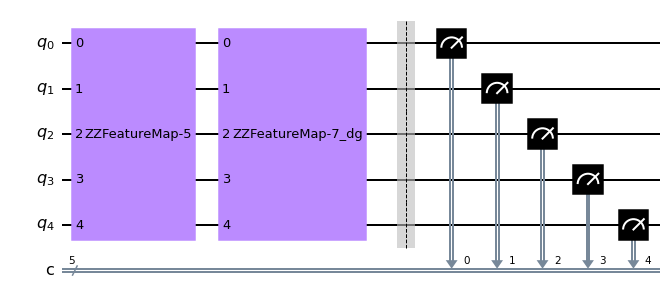

In [7]:
# encode data via ZZ feature map
map_z = ZZFeatureMap(feature_dimension=5, reps=3, entanglement='linear')

# create kernel circuit
z_kernel = QuantumKernel(feature_map=map_z, quantum_instance=qinst)

# draw circuit for first row of inputs
kernel_qc = z_kernel.construct_circuit(X_tr_pca[0])
kernel_qc.draw('mpl')

In [8]:
# find kernel matrices
train_matrix= z_kernel.evaluate(x_vec=X_tr_pca[0:100,:])
test_matrix = z_kernel.evaluate(x_vec=X_va_pca[0:100,:], y_vec=X_tr_pca[0:100,:])

# show kernel
fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

## Classical Support Vector Classification

In [10]:
model = SVC(kernel=z_kernel.evaluate)
model.fit(X_tr_pca[0:100,:], Y_tr[0:100])
score = model.score(X_va_pca[0:100,:], Y_va[0:100])

/opt/homebrew/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [11]:
print(score)

0.96
